# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [362]:
#pip install scipy==1.2.0

In [363]:
import numpy as np
import os

import datetime
import matplotlib.pyplot as plt
import imageio

#scipy.imread
#from scipy.misc import imresize
import imageio
from PIL import Image
from skimage.transform import resize


We set the random seed so that the results don't vary drastically.

In [364]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

tf.random.set_seed(30)
import pathlib
import glob as glob
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, TimeDistributed, GRU



In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [365]:
train_doc = np.random.permutation(open(r'C:\Users\Aman\anaconda3\Upgrad\RNN\RNN_Assignment\Project_data\train.csv').readlines())
val_doc = np.random.permutation(open(r'C:\Users\Aman\anaconda3\Upgrad\RNN\RNN_Assignment\Project_data\val.csv').readlines())
batch_size = 64 #experiment with the batch size

In [366]:
# Shows the first record from train_csv file
train_doc[0]

'WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n'

In [367]:
print('Total Number of videos in training data : ', len(train_doc))
print('Total Number of videos in validation data : ', len(val_doc))

Total Number of videos in training data :  663
Total Number of videos in validation data :  100


In [368]:
train_path = r'C:\Users\Aman\anaconda3\Upgrad\RNN\RNN_Assignment\Project_data\train'
val_path = r'C:\Users\Aman\anaconda3\Upgrad\RNN\RNN_Assignment\Project_data\val'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of images in training data :  19890
Number of images in validations data :  3000


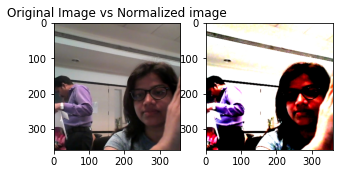

In [369]:
from glob import glob

train_image_path = [ x for x in glob(os.path.join(train_path,'*','*.png'))]

val_image_path = [ x for x in glob(os.path.join(val_path,'*','*.png'))]

print('Number of images in training data : ', str(len(train_image_path)))
print('Number of images in validations data : ', str(len(val_image_path)))

# Read the first training image 
image = imageio.imread(train_image_path[0])

norm_image = (image - image.std())/ (image.std())

plt.figure(figsize = (5,5))

plt.subplot(1,2,1)
plt.title('Original Image vs Normalized image')
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(norm_image)

In [370]:
# Count of number of unique frames in each video 

a=[]

for index , i in enumerate(glob(os.path.join(train_path,'*'))) :
    
    for k,j in enumerate(glob(os.path.join(i,'*.png'))) :
        k = k+1
    a.append(k)
    
print('Number of unique frames in each video : ' ,  set(a))

Number of unique frames in each video :  {30}


In [371]:
# To check the different unique size of images in training data 

orig_image_size  =[]

for index , i in enumerate(glob(os.path.join(train_path,'*'))) :
    b= imageio.imread(glob(os.path.join(i,'*.png'))[0]).shape

    orig_image_size.append(b)

print('Different Unique image sizesin training data : ', set(orig_image_size))  

Different Unique image sizesin training data :  {(120, 160, 3), (360, 360, 3)}


# To comapre the impact on original image of size (120,160,3) after cropping and resizing for three different images 

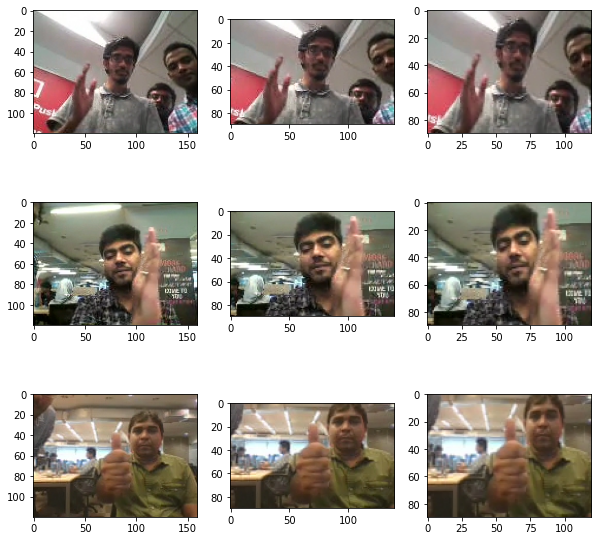

In [372]:
counter =1

plt.figure(figsize=(10, 10))

for index , i in enumerate(glob(os.path.join(train_path,'*'))) :
      
    train_images = imageio.imread(glob(os.path.join(i,'*.png'))[0]) 
         
    if train_images.shape == (120,160,3) and counter <= 9:
           
        plt.subplot(3, 3,counter) 
        plt.imshow(train_images)
        
        plt.subplot(3,3,counter+1)
        cropped_image = train_images[20:110,10:150]
        plt.imshow(cropped_image)
        
        plt.subplot(3,3,counter+2)
        image_resize = resize(cropped_image , (90, 120))
        plt.imshow(image_resize)
   
        counter= counter+3

# To comapre the impact on original image of size (360,360,3) after cropping and resizing for three different images 

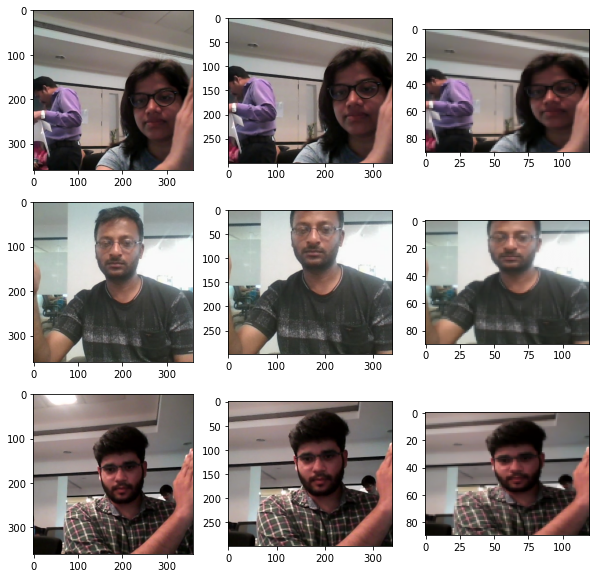

In [373]:

counter =1

plt.figure(figsize=(10, 10))

for index , i in enumerate(glob(os.path.join(train_path,'*'))) :
      
    train_images = imageio.imread(glob(os.path.join(i,'*.png'))[0]) 
       
    if train_images.shape == (360,360,3) and counter <= 9:
           
        plt.subplot(3, 3,counter) 
        plt.imshow(train_images)
        
        plt.subplot(3,3,counter+1)
        cropped_image = train_images[50:350,10:350]
        plt.imshow(cropped_image)
        
        plt.subplot(3,3,counter+2)
        image_resize = resize(cropped_image , (90, 120))
        plt.imshow(image_resize)
   
        counter= counter+3


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [374]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = [0,2,4,6,8,10,12,14,16,18, 20, 22,24,26,28] #create a list of image numbers you want to use for a particular video
    
    img_idx = [1,4,7,10,13,16,19,22,25,28]
    
    x = len(img_idx)
    y = 90 # height
    z = 120   # width

    while True:
        t = np.random.permutation(folder_list)
        num_batches = int((len(folder_list))/ (batch_size)) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                                    
                                       
                    if image.shape == (360,360,3) :
                        image = image[50:350,10:350]
                    
                    else :
                        image = image[20:110,10:150]
                                         
                    image = resize(image , (y, z))
                    
                    #batch_data[folder,idx,:,:,0] = (image[:,:,0]  - image.mean())/ (image.std())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (image[:,:,1]  - image.mean())/ (image.std())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (image[:,:,2]  - image.mean())/ (image.std())#normalise and feed in the image
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/ (255)  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/(255) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/ (255) #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        
        # Last batch size is calculated by difference between number of videos and number of videos used in earlier batches
        
        last_batch_size = len(folder_list) - (batch_size * num_batches)
        # Last batch number will be equal to number of earlier batches + 1 
        last_batch = num_batches+1
        
        for batch in range(num_batches, last_batch):
            last_batch_data = np.zeros((last_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            last_batch_labels = np.zeros((last_batch_size,5)) # batch_labels is the one hot representation of the output
        
            for folder in range(last_batch_size): # iterate over the batch_size
   
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*last_batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if image.shape == (360,360,3) :                            
                        image = image[50:350,10:350]
                    
                    else :                        
                        image = image[20:110,10:150]
                    
                    image = resize(image , (y, z)) # resize the image to 90 height and 120 width      
                 
                  
                    #last_batch_data[folder,idx,:,:,0] = (image[:,:,0]  - image.mean())/ (image.std())#normalise and feed in the image
                    #last_batch_data[folder,idx,:,:,1] = (image[:,:,1]  - image.mean())/ (image.std())#normalise and feed in the image
                    #last_batch_data[folder,idx,:,:,2] = (image[:,:,2]  - image.mean())/ (image.std())#normalise and feed in the image
                    
                    last_batch_data[folder,idx,:,:,0] = (image[:,:,0])/ (255) #normalise and feed in the image
                    last_batch_data[folder,idx,:,:,1] = (image[:,:,1])/ (255) #normalise and feed in the image
                    last_batch_data[folder,idx,:,:,2] = (image[:,:,2])/ (255) #normalise and feed in th
                    
                last_batch_labels[folder, int(t[folder + (batch*last_batch_size)].strip().split(';')[2])] = 1
            yield last_batch_data, last_batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [375]:
curr_dt_time = datetime.datetime.now()
train_path = r'C:\Users\Aman\anaconda3\Upgrad\RNN\RNN_Assignment\Project_data\train'
val_path = r'C:\Users\Aman\anaconda3\Upgrad\RNN\RNN_Assignment\Project_data\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [376]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

In [377]:
input_shape = (10,90, 120, 3)

cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu', padding = 'same'))

cnn.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same') )   # padding is added
cnn.add(MaxPooling2D(pool_size=(2,2) ))
cnn.add(Dropout(0.25))
          
cnn.add(Conv2D(64, kernel_size = (3,3), activation = 'relu') )
#cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2) ))
cnn.add(Dropout(0.25))
          
cnn.add(Conv2D(64, kernel_size = (3,3), activation = 'relu') )
#cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2) ))
cnn.add(Dropout(0.25))



cnn.add(Flatten()) 

model = Sequential()
model.add(TimeDistributed(cnn, input_shape = input_shape))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2, activation = 'tanh' ))  

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.35))

model.add(Dense(256, activation = 'relu')) 
model.add(Dropout(0.35))
model.add(Dense(5, activation="softmax"))

model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 15, 7488)          65568     
_________________________________________________________________
gru_30 (GRU)                 (None, 128)               2925312   
_________________________________________________________________
dense_98 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_178 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_179 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 5)               

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [378]:
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 15, 7488)          65568     
_________________________________________________________________
gru_30 (GRU)                 (None, 128)               2925312   
_________________________________________________________________
dense_98 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_178 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_179 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 5)               

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [379]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [380]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001)   # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [381]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [382]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:\Users\Aman\anaconda3\Upgrad\RNN\RNN_Assignment\Project_data\train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.6311 - categorical_accuracy: 0.2187 Source path =  C:\Users\Aman\anaconda3\Upgrad\RNN\RNN_Assignment\Project_data\val ; batch size = 64

Epoch 00001: saving model to model_init_2021-03-2916_26_40.403660\model-00001-1.63114-0.21870-1.60677-0.20000.h5
11/11 [==============================] - 170s 15s/step - loss: 1.6311 - categorical_accuracy: 0.2187 - val_loss: 1.6068 - val_categorical_accuracy: 0.2000
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.6027 - categorical_accuracy: 0.2413 
Epoch 00002: saving model to model_init_2021-03-2916_26_40.403660\model-00002-1.60269-0.24133-1.58650-0.40000.h5
11/11 [==============================] - 160s 15s/step - loss: 1.6027 - categorical_accuracy: 0.2413 - val_loss: 1.5865 - val_categorical_accuracy: 0.4000
Epoch 3/20
11/11 [==============================

# Plot training accuracy vs validation accuracy and training loss vs validation loss

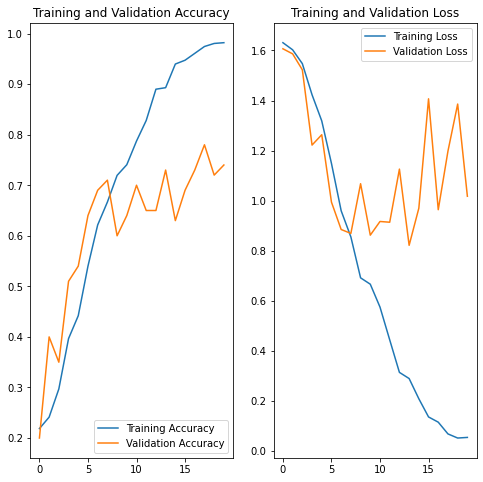

In [383]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Conv3D

In [424]:
class Batch_Data_Generator: 
    
    def __init__(self, source_path, folder_list, frames = 10,  dim = (120, 120), n_channels = 3):

        self.dim = dim
        self.n_channels = n_channels
        self.source_path = source_path
        self.folder_list = folder_list
        self.frames = frames
        
    def initialize_batch_data(self, batch_size, x = len(range(0, 30, 3)), y = None, z = None): 

        if y == None: 
            y = self.dim[0]
        if z == None: 
            z = self.dim[1]
             
        batch_data = np.zeros((batch_size, x, y, z, 3)) # x - no of frames from each video,  (y, z) - size of the resized image
        batch_labels = np.zeros((batch_size, 5)) # one hot encoded class labels
        
        return batch_data, batch_labels
    
    def normalize_image(self, image, channel): 
        return image[:,:,channel] - np.mean(image[:,:,channel]) / (np.std(image[:,:,channel]))
    
    def load_batch_frames(self, batch_num, batch_size, t):
        
        step_size = [2, 3, 4, 5, 6, 7, 8]
        no_frames = [15, 10, 8, 6, 5, 5, 4]

        for frame in no_frames: 
            if frame == self.frames: 
                step = step_size[no_frames.index(frame)]
            
            else: 
                frame = 10
                step = 3
          
        img_idx = list(range(0, 30, step))

        batch_data, batch_labels = self.initialize_batch_data(batch_size, x = len(img_idx))
         
        for folder in range(batch_size): 
            imgs = os.listdir(self.source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])

            for idx, item in enumerate(img_idx): 
                
                image = imageio.imread(self.source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                         
                if image.shape == (360,360,3):
                        
                    image = image[30:350, 10:350]
                else:       
                    image = image[20:110, 10:150]
                    
                image_resized = resize(image, self.dim)
                
                image_resized[:, :, 0] = self.normalize_image(image_resized, 0)
                image_resized[:, :, 1] = self.normalize_image(image_resized, 1)
                image_resized[:, :, 2] = self.normalize_image(image_resized, 2)
                
                batch_data[folder, idx] = image_resized

                #batch_data[folder, idx] = tf.image.rgb_to_grayscale(image_resized)
                
            batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1

        return batch_data, batch_labels
    
    def generator(self, batch_size): 
        
        print("Source path = ", self.source_path, "\nbatch size = ", batch_size)
        
        while True: 
            t = np.random.permutation(self.folder_list)
            num_batches = int((len(self.folder_list))/ (batch_size))
            
            for batch in range(num_batches): 
                yield self.load_batch_frames(batch, batch_size, t)
                
            last_batch_size = (len(self.folder_list))  -  (batch_size * num_batches)
            last_batch = num_batches + 1

            for batch in range(num_batches, last_batch):
                yield self.load_batch_frames(batch, last_batch_size, t) 


In [425]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, SimpleRNN, Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import  Conv3D, MaxPooling3D, ZeroPadding3D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

In [426]:
# Batch Data generator using generator class objects
batch_size = 64
train_generator = Batch_Data_Generator(source_path = train_path, folder_list = train_doc, frames = 10).generator(batch_size = batch_size)
val_generator = Batch_Data_Generator(source_path = val_path, folder_list = val_doc, frames = 10).generator(batch_size = batch_size)

In [427]:
input_shape = (10, 120, 120, 3)


model3 = Sequential()

# CNN unit 1
model3.add(Conv3D(16, 
                 kernel_size=(4, 4, 4), 
                 input_shape=input_shape,
                 padding='same'))
model3.add(Activation('relu'))
model3.add(Dropout(0.1))
model3.add(MaxPooling3D(pool_size=(2, 2, 2), data_format = 'channels_last'))



# CNN unit 2
model3.add(Conv3D(16, 
                 kernel_size=(4, 4, 4), 
                 padding='same'))
model3.add(Activation('relu'))
model3.add(Dropout(0.25))
model3.add(MaxPooling3D(pool_size=(2, 2, 2), data_format = 'channels_last'))



# CNN unit 3
model3.add(Conv3D(32, 
                 kernel_size=(3, 3, 3), 
                 padding='same'))
model3.add(Activation('relu'))
model3.add(Dropout(0.25))
model3.add(MaxPooling3D(pool_size=(2, 2, 2), data_format = 'channels_last'))


# CNN unit 4

model3.add(Conv3D(64, 
                 kernel_size=(3, 3, 3), 
                 padding='same'))
model3.add(Activation('relu'))
model3.add(Dropout(0.25))
model3.add(ZeroPadding3D(padding = (1, 1, 1)))
model3.add(MaxPooling3D(pool_size=(2,2,2), data_format = 'channels_last'))



#Flatten Layers

model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.25))

#softmax layer
model3.add(Dense(5, activation='softmax'))

In [428]:
model3.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 10, 120, 120, 16)  3088      
_________________________________________________________________
activation_20 (Activation)   (None, 10, 120, 120, 16)  0         
_________________________________________________________________
dropout_210 (Dropout)        (None, 10, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 5, 60, 60, 16)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 5, 60, 60, 16)     16400     
_________________________________________________________________
activation_21 (Activation)   (None, 5, 60, 60, 16)     0         
_________________________________________________________________
dropout_211 (Dropout)        (None, 5, 60, 60, 16)   

In [429]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)   # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [430]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
num_epochs = 20
history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers= -1, initial_epoch=0)

Source path =  C:\Users\Aman\anaconda3\Upgrad\RNN\RNN_Assignment\Project_data\train 
batch size =  64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 9.5184 - categorical_accuracy: 0.2172 Source path =  C:\Users\Aman\anaconda3\Upgrad\RNN\RNN_Assignment\Project_data\val 
batch size =  64

Epoch 00001: saving model to model_init_2021-03-2916_26_40.403660\model-00001-9.51836-0.21719-1.59705-0.30000.h5
11/11 [==============================] - 307s 28s/step - loss: 9.5184 - categorical_accuracy: 0.2172 - val_loss: 1.5971 - val_categorical_accuracy: 0.3000
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.5951 - categorical_accuracy: 0.2504 
Epoch 00002: saving model to model_init_2021-03-2916_26_40.403660\model-00002-1.59515-0.25038-1.59434-0.21000.h5
11/11 [==============================] - 419s 38s/step - loss: 1.5951 - categorical_accuracy: 0.2504 - val_loss: 1.5943 - val_categorical_accuracy: 0.2100
Epoch 3/20
11/11 [==============================

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()